In [38]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
import sys
import copy
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from graphviz import Source

sys.path.append("../main")
from tree import *
from rules import *
from tree_rules import *
from rule_clustering import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [3]:
pal = sns.color_palette("husl", 8)
cmap = LinearSegmentedColormap.from_list("seaborn_colors", pal)

custom_palette = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']
custom_palette = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000', '#F36F47', '#604D79', '#8E45CB']
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette)

tab20 = plt.get_cmap('tab20')
subset_colors = [tab20(2), tab20(4), tab20(9)]
cmap_subset = ListedColormap(subset_colors)

In [4]:
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
'''
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 24
})
'''
colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)

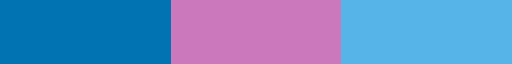

In [5]:
cmap_subset

## Simple Dataset

In [6]:
n = 2000
m = 2
k = 3

random_state = 170
data, labels = datasets.make_blobs(
    n_samples=n, cluster_std=[1.0, 2.5, 0.5], random_state=seed
)
data = preprocessing.MinMaxScaler().fit_transform(data)

Text(0, 0.5, 'y')

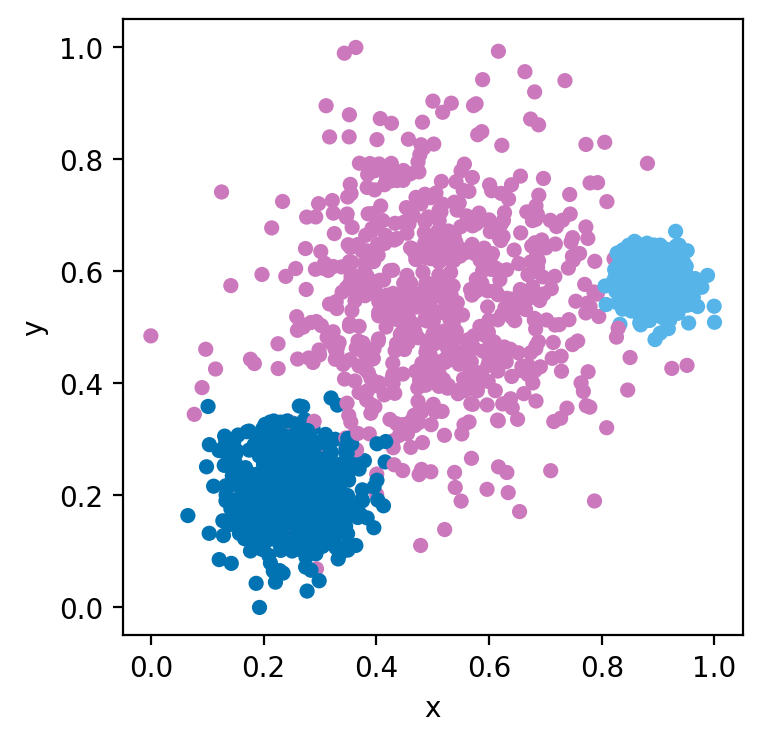

In [56]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
ax.scatter(data[:,0], data[:,1], c = labels, cmap = cmap_subset, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')

### Kmeans baseline

In [115]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)

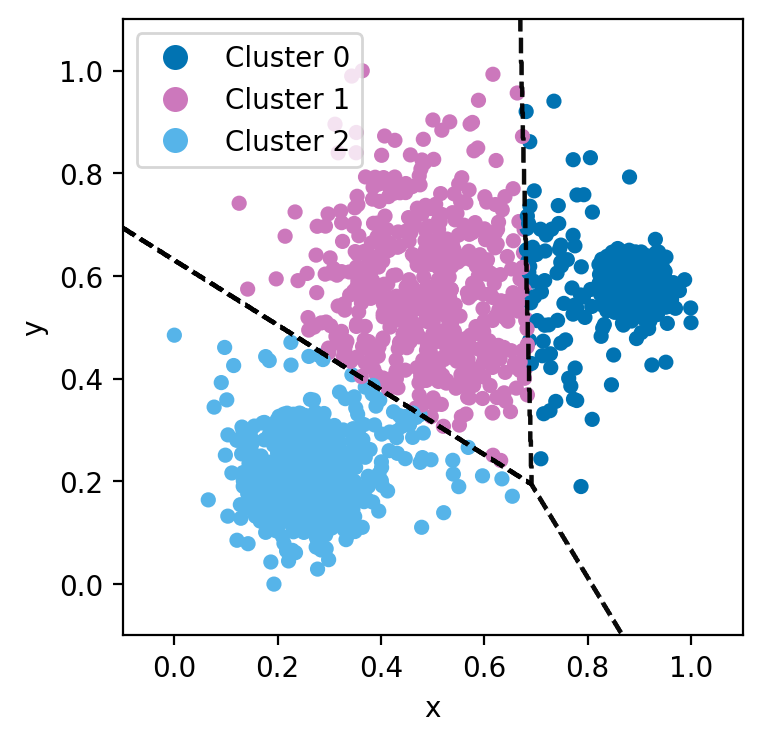

In [116]:
colorswitch = {0:2, 1:0, 2:1}
kmeans_labels_ = np.array([colorswitch[i] for i in kmeans.labels_])
fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000)

unique_labels = np.unique(kmeans.labels_)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(handles=handles, loc = 'upper left')

In [117]:
kmeans_cost(data, labels_to_clustering(kmeans.labels_), kmeans.cluster_centers_)

27.890054453649658

### ExKMC Baseline

In [11]:
ExKMC_tree = ExTree(k, max_leaves = 6)
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)

Text(0, 0.5, 'y')

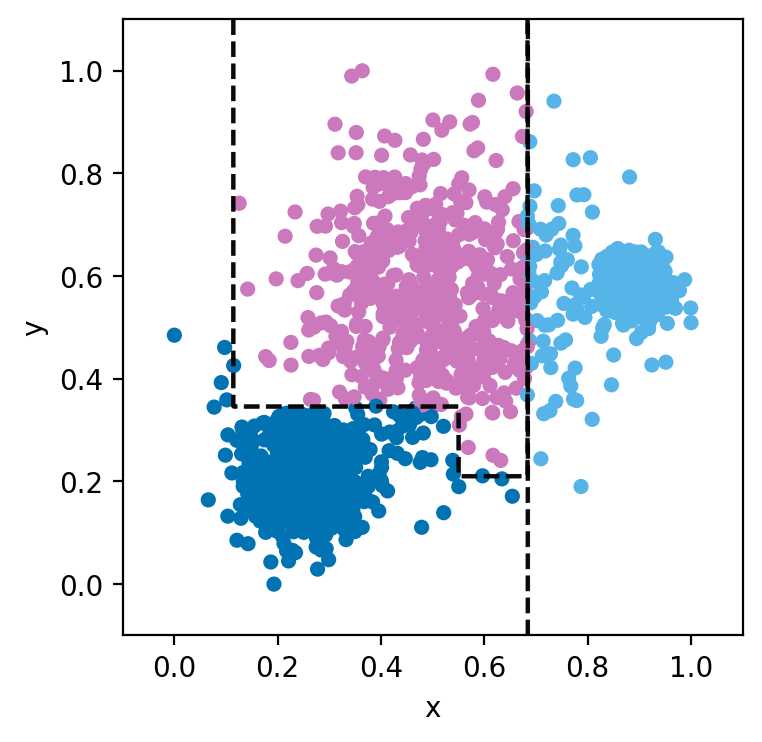

In [58]:
colorswitch = {0:2, 1:0, 2:1}
exkmc_labels_ = np.array([colorswitch[i] for i in exkmc_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
ax.scatter(data[:,0], data[:,1], c = exkmc_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(ExKMC_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

# Creating Rule sets

### Grid Partition

In [13]:
cells = 5
grid = rule_grid(data,cells)
# This actually does a clustering with cells x cells clusters just for visualization purposes
grid_rules = RuleClustering(grid, k_clusters = cells**2)
grid_rules.fit_rules(data)
grid_labels = grid_rules.predict(data)

Text(0, 0.5, 'y')

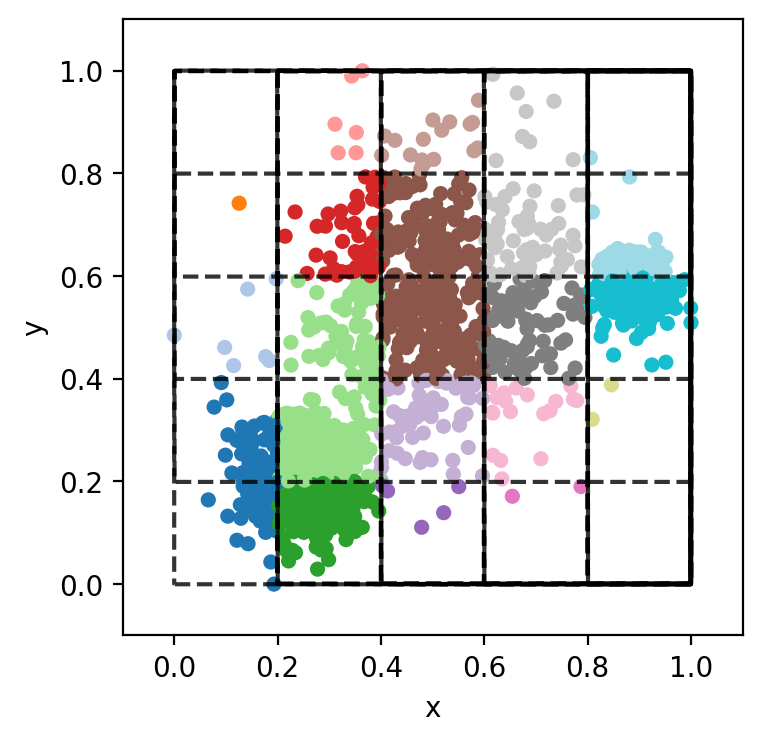

In [59]:
#scatter = plt.scatter(data2[select,0], data2[select,1])
fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
ax.scatter(data[:,0], data[:,1], c = grid_labels, cmap = 'tab20', s = 20)
plot_decision_boundaries(grid_rules, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### k-Means Tree Partition

In [19]:
kmeans_tree = KMeansTree(max_leaf_nodes = 6, min_points_leaf = 1)
kmeans_tree.fit(data)
kmeans_tree_labels = kmeans_tree.predict(data)

Text(0, 0.5, 'y')

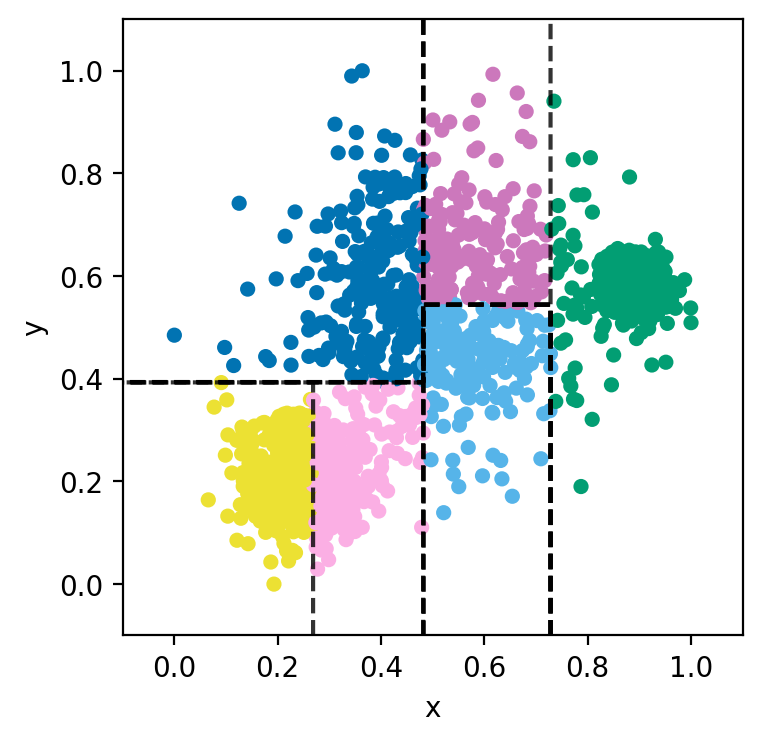

In [60]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

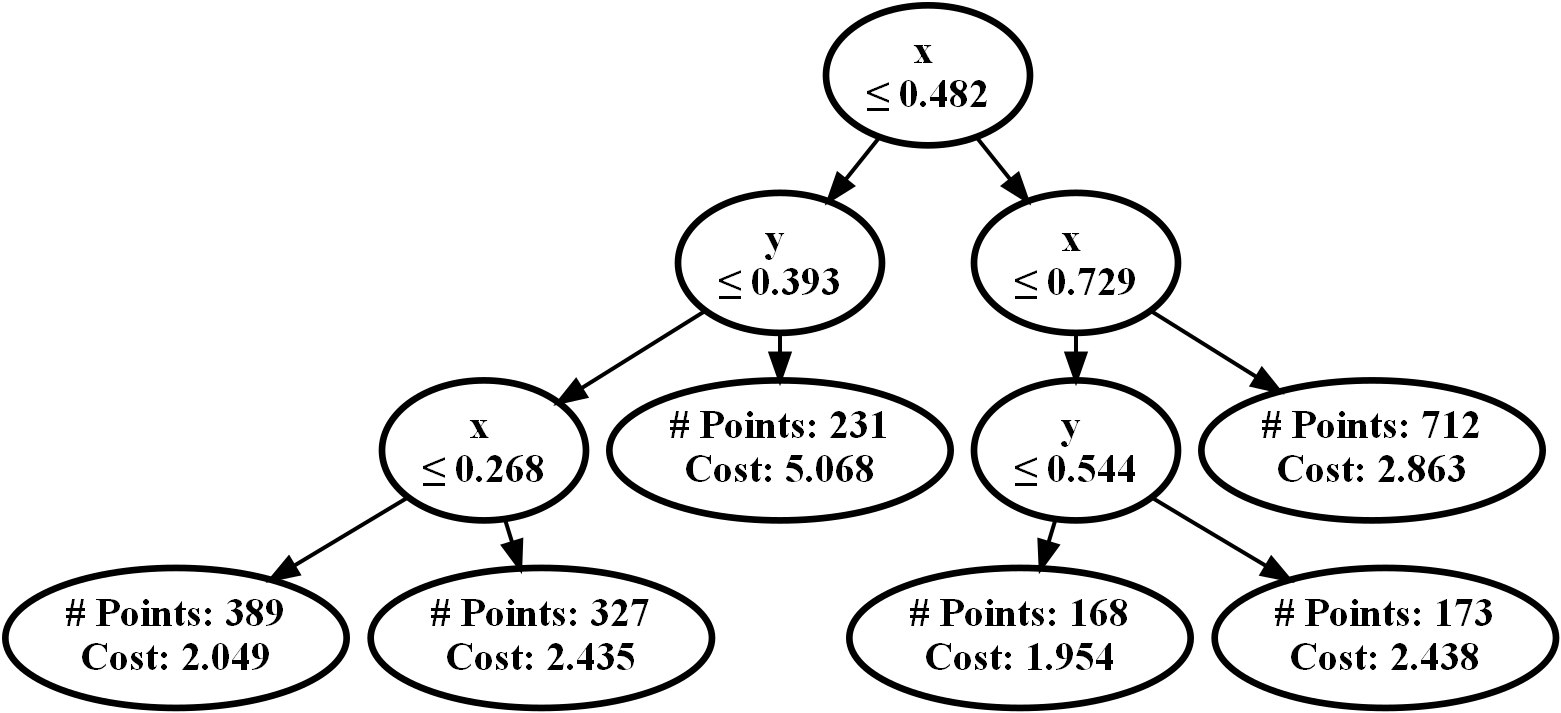

In [61]:
visualize_tree(kmeans_tree.root, feature_labels = ['x', 'y'])

In [21]:
tree_traverse = tree_to_rules()
kmeans_rules = tree_traverse.traverse(kmeans_tree.root)
leaf_node_labels = tree_traverse.leaf_node_labels

In [22]:
kmeans_rules

[(x0 <= 0.4818446633222401  ∧  x1 <= 0.3925631481508086  ∧  x0 <= 0.2677466321927099),
 (x0 <= 0.4818446633222401  ∧  x1 <= 0.3925631481508086  ∧  x0 > 0.2677466321927099),
 (x0 <= 0.4818446633222401  ∧  x1 > 0.3925631481508086),
 (x0 > 0.4818446633222401  ∧  x0 <= 0.7285337832335166  ∧  x1 <= 0.5441114975168548),
 (x0 > 0.4818446633222401  ∧  x0 <= 0.7285337832335166  ∧  x1 > 0.5441114975168548),
 (x0 > 0.4818446633222401  ∧  x0 > 0.7285337832335166)]

### k-Medians Tree Partition

In [24]:
kmedians_tree = KMediansTree(max_leaf_nodes = 6, min_points_leaf = 1)
kmedians_tree.fit(data)
kmedians_tree_labels = kmedians_tree.predict(data)

Text(0, 0.5, 'y')

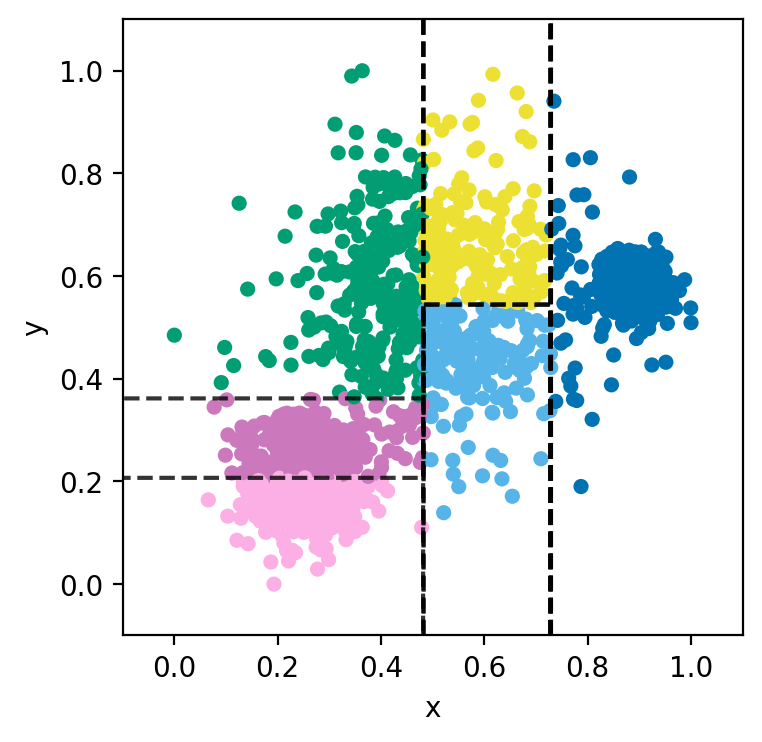

In [62]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = kmedians_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmedians_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [26]:
kmedians_rules = tree_to_rules().traverse(kmedians_tree.root)

### ExKMC Tree

In [110]:
# ExKMC
ExKMC_tree = ExTree(k, max_leaves = 6)
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)
exkmc_tree = ConvertExKMC(ExKMC_tree.tree, data)
exkmc_tree_labels = exkmc_tree.predict(data)

Text(0, 0.5, 'y')

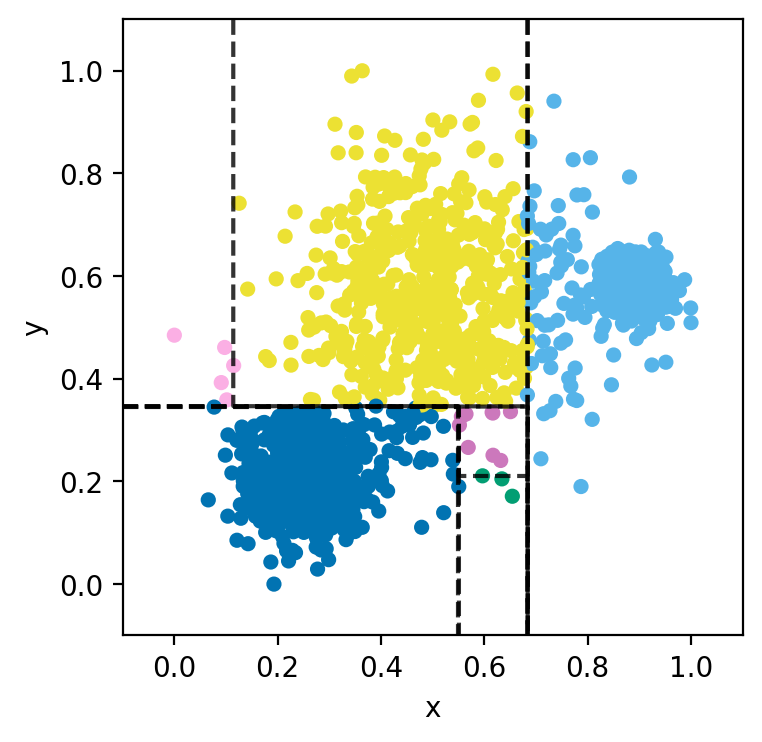

In [63]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = exkmc_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(exkmc_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [29]:
exkmc_rules = tree_to_rules().traverse(exkmc_tree.root)

# Rule Clustering

### 1. k-Means

In [96]:
rule_kmeans = KMeansRuleClustering(grid, k_clusters = k, init = 'k-means')
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
rule_kmeans_labels = rule_kmeans.predict(data)

In [97]:
rule_kmeans.iterations

2

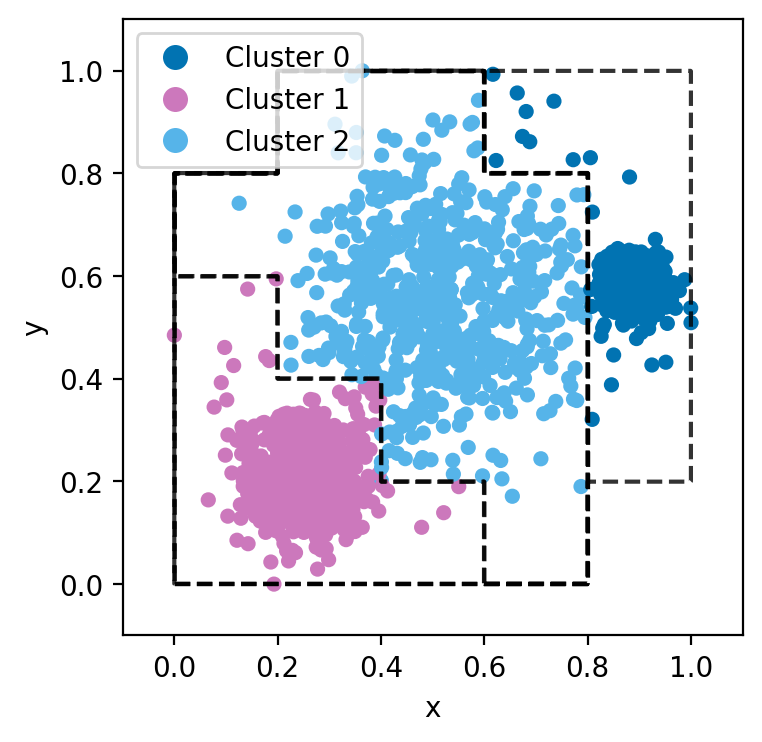

In [98]:
#plt.scatter(rule_kmeans.centers[:,0], rule_kmeans.centers[:,1], color = 'k', marker = 'x', s = 100)
colorswitch = {0:1, 1:0, 2:2}
rule_kmeans_labels_ = np.array([colorswitch[i] for i in rule_kmeans_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = rule_kmeans_labels, cmap = cmap_subset, s = 20)
plot_decision_boundaries(rule_kmeans, data, ax = ax, resolution = 1000)

unique_labels = np.unique(rule_kmeans_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {int(label)}') 
           if label != -1 else plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') 
        for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(handles=handles, loc = 'upper left')

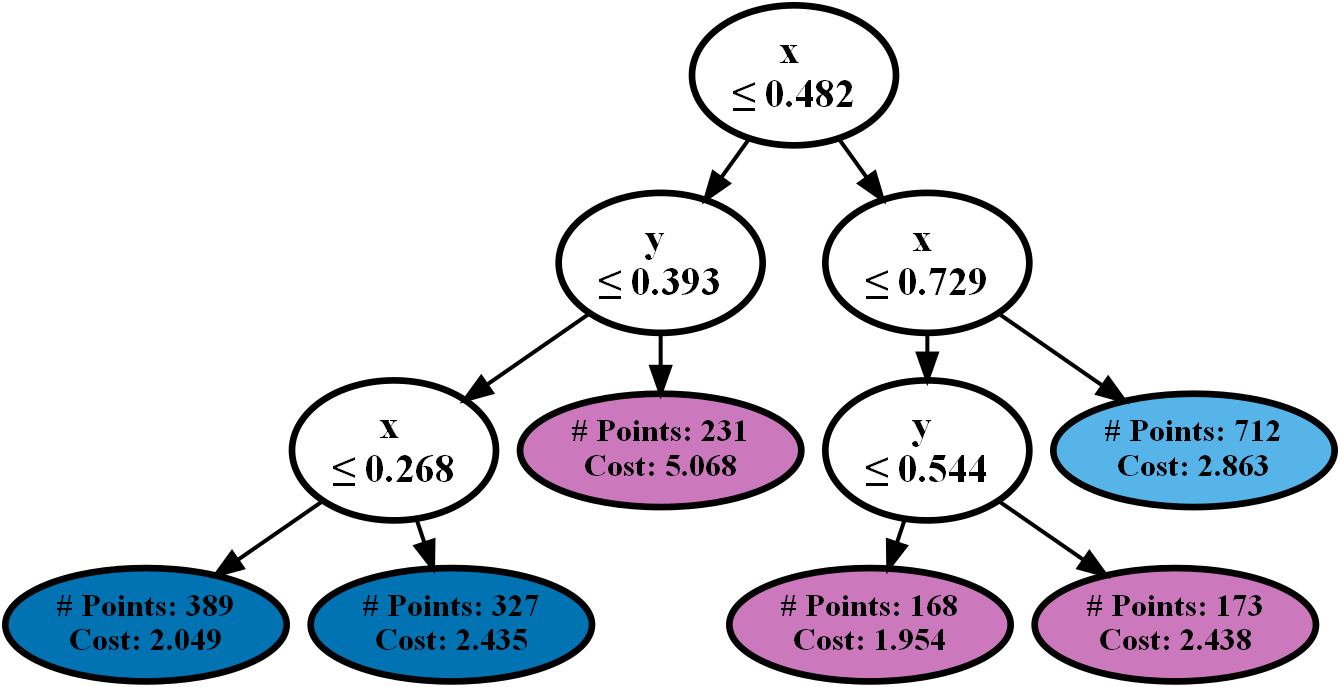

In [65]:
rule_labels_ = [colorswitch[i] for i in rule_labels]
leaf_colors = {leaf_node_labels[i]:mcolors.rgb2hex(cmap_subset(rule_labels_[i]), keep_alpha=True) for i in range(len(leaf_node_labels))}
visualize_tree(kmeans_tree.root, feature_labels = ['x', 'y'], leaf_colors = leaf_colors)

In [148]:
print(rule_kmeans)

IF:
(x0 > 0.683189395126272)
THEN CLUSTER 0

IF:
(x1 <= 0.3467226668645854  ∧  x0 <= 0.5504677135763472)  ∨  
(x0 <= 0.683189395126272  ∧  x0 > 0.5504677135763472  ∧  x1 <= 0.21093899149602607)  ∨  
(x1 > 0.3467226668645854  ∧  x0 <= 0.11478821946041329)
THEN CLUSTER 1

IF:
(x0 <= 0.683189395126272  ∧  x1 <= 0.3467226668645854  ∧  x0 > 0.5504677135763472  ∧  x1 > 0.21093899149602607)  ∨  
(x0 <= 0.683189395126272  ∧  x1 > 0.3467226668645854  ∧  x0 > 0.11478821946041329)
THEN CLUSTER 2



In [119]:
leaves = list(range(4,32))
exkmc_cost_by_leaves = []
rule_cost_by_leaves = []
rule_cost_by_leaves1 = []

for l in leaves:
    # ExKMC    
    ExKMC_tree_ = ExTree(k, max_leaves = l)
    exkmc_labs = ExKMC_tree_.fit_predict(data, kmeans)
    exkmc_cost = kmeans_cost(data, labels_to_clustering(exkmc_labs), kmeans.cluster_centers_)
    exkmc_cost_by_leaves.append(exkmc_cost)
    exkmc_tree_ = ConvertExKMC(ExKMC_tree_.tree, data)
    exkmc_rules_ = tree_to_rules().traverse(exkmc_tree_.root)

    # Rule Kmeans
    kmeans_tree_ = KMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree_.fit(data)
    kmeans_rules_ = tree_to_rules().traverse(kmeans_tree_.root)
    
    rule_kmeans_ = KMeansRuleClustering(kmeans_rules_, k_clusters = k, init = 'k-means')
    rule_kmeans_.fit(data)
    rule_kmeans_labs = rule_kmeans_.predict(data)

    cluster_cost = kmeans_cost(data, labels_to_clustering(rule_kmeans_labs), rule_kmeans_.centers)
    rule_cost_by_leaves.append(cluster_cost)

    # Rule ExKMC KMeans
    rule_kmeans_1 = KMeansRuleClustering(exkmc_rules_, k_clusters = k, init = 'k-means')
    rule_kmeans_1.fit(data)
    rule_kmeans_labs1 = rule_kmeans_1.predict(data)

    cluster_cost1 = kmeans_cost(data, labels_to_clustering(rule_kmeans_labs1), rule_kmeans_1.centers)
    rule_cost_by_leaves1.append(cluster_cost1)

In [99]:
# Rule Grid KMeans
rule_kmeans_2 = KMeansRuleClustering(grid, k_clusters = k, init = 'k-means')
rule_kmeans_2.fit(data)
rule_kmeans_labs2 = rule_kmeans_2.predict(data)

rule_grid_cost = kmeans_cost(data, labels_to_clustering(rule_kmeans_labs2), rule_kmeans_2.centers)

In [70]:
# Svensson Random Tree for comparison:
random_tree_cost = np.inf
for i in range(10000):
    random_tree = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree.fit(kmeans.cluster_centers_)
    random_tree_labels = random_tree.predict(data)
    rcost = kmeans_cost(data, labels_to_clustering(random_tree_labels), kmeans.cluster_centers_)
    if rcost < random_tree_cost:
        random_tree_cost = rcost

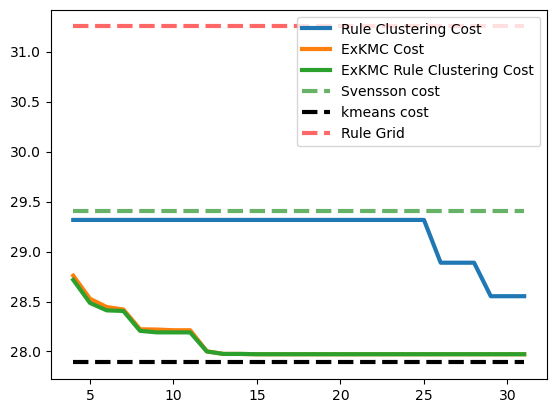

In [120]:
plt.plot(leaves, rule_cost_by_leaves, linewidth = 3, label = 'Rule Clustering Cost')
plt.plot(leaves, exkmc_cost_by_leaves, linewidth = 3, label = 'ExKMC Cost')
plt.plot(leaves, rule_cost_by_leaves1, linewidth = 3, label = 'ExKMC Rule Clustering Cost')
plt.hlines(random_tree_cost, xmin = leaves[0], xmax = leaves[-1], color = 'green', linestyle = '--', label = 'Svensson cost', linewidth = 3, alpha = 0.6)
plt.hlines(kmeans_cost(data, labels_to_clustering(kmeans.labels_), kmeans.cluster_centers_), xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'kmeans cost', linewidth = 3)
plt.hlines(rule_grid_cost, xmin = leaves[0], xmax = leaves[-1], color = 'red', linestyle = '--', label = 'Rule Grid', linewidth = 3, alpha = 0.6)
plt.legend()

### 2. k-Medians

In [73]:
rule_kmedians = KMediansRuleClustering(kmedians_rules, k_clusters = k)
rule_kmedians.fit(data)
rule_kmedians_labels = rule_kmedians.predict(data)

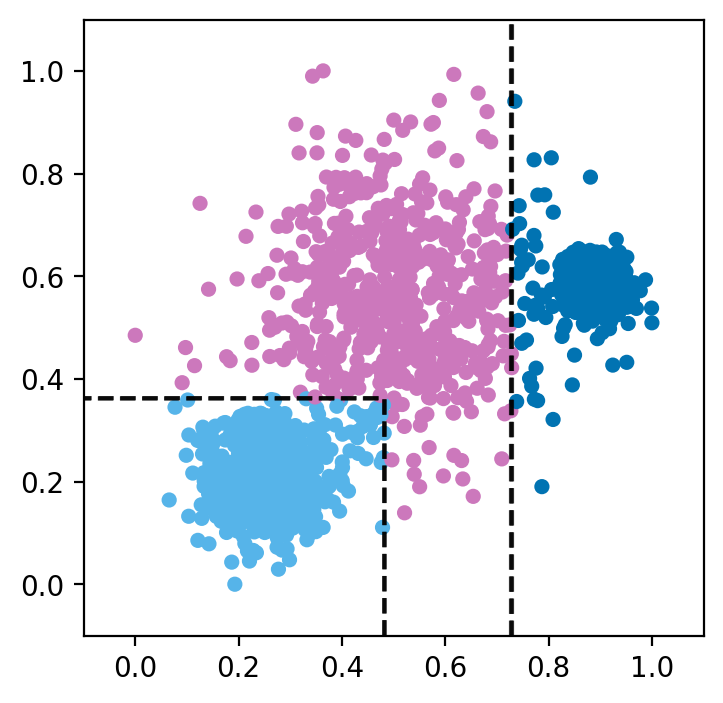

In [75]:
#plt.scatter(rule_kmeans.centers[:,0], rule_kmeans.centers[:,1], color = 'k', marker = 'x', s = 100)
colorswitch = {0:1, 1:0, 2:2}
rule_kmedians_labels_ = np.array([colorswitch[i] for i in rule_kmedians_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = rule_kmedians_labels, cmap = cmap_subset, s = 20)
plot_decision_boundaries(rule_kmedians, data, ax = ax, resolution = 1000)

# Dataset Demonstration

In [77]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), np.zeros(n_samples)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

dataset_list = [noisy_circles, noisy_moons, blobs, aniso, varied, no_structure]

C:\Users\kq146\AppData\Local\Temp\ipykernel_28892\3927023097.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


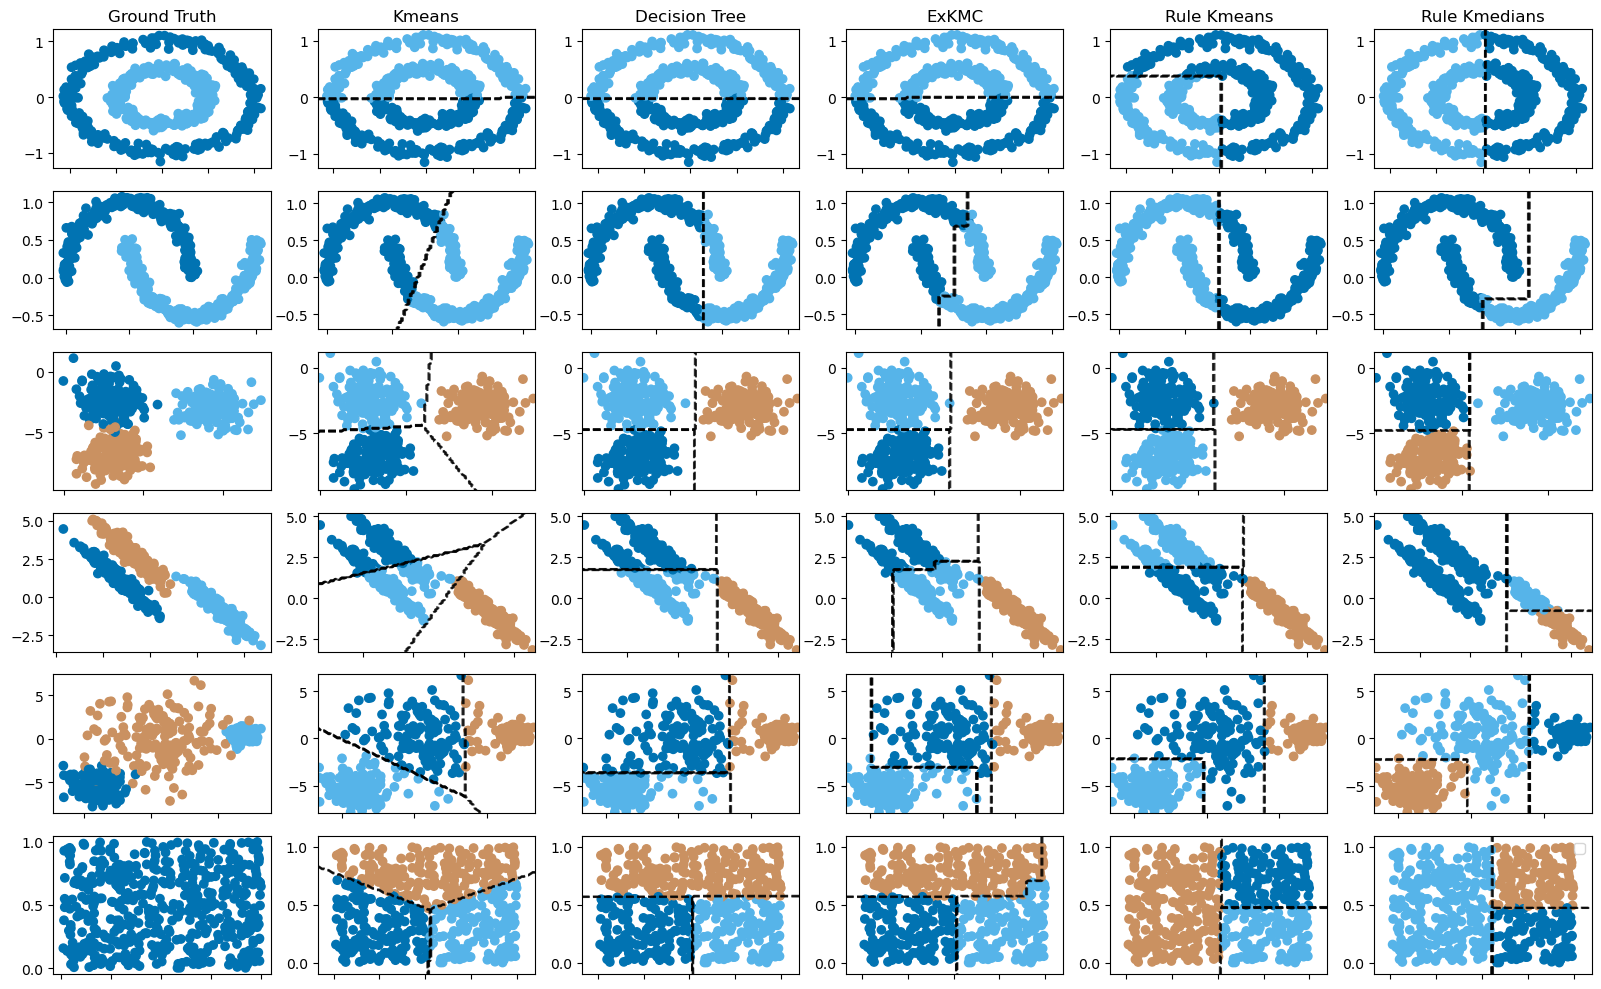

In [78]:
# Cluster and display Results
fig,axes = plt.subplots(6,6, figsize = (16,10))

# For each of the datasets do clusters
for d in range(len(dataset_list)):
    # Set titles
    if d == 0:
        axes[d,0].set_title('Ground Truth')
        axes[d,1].set_title('Kmeans')
        axes[d,2].set_title('Decision Tree')
        axes[d,3].set_title('ExKMC')
        axes[d,4].set_title('Rule Kmeans')
        axes[d,5].set_title('Rule Kmedians')
        #axes[d,5].set_title('Rule Agglomerative')
    
    X,y = dataset_list[d]

    # determine the number of clusters
    if np.sum(y) == 0:
        n_clusters = 3
    else:
        n_clusters = len(np.unique(y))

    # Baseline:
    axes[d,0].scatter(X[:,0], X[:,1], c = y, cmap = cmap)
    axes[d,0].set_xticklabels([])

    # Kmeans:
    kmeans = KMeans(n_clusters=n_clusters, random_state=39, n_init="auto").fit(X)
    axes[d,1].scatter(X[:,0], X[:,1], c = kmeans.labels_, cmap = cmap)
    plot_decision_boundaries(kmeans, X, ax = axes[d,1])
    axes[d,1].set_xticklabels([])

    # Decision tree
    tree = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = n_clusters).fit(X, kmeans.labels_)
    tree_labels = tree.predict(X)
    axes[d,2].scatter(X[:,0], X[:,1], c = tree_labels, cmap = cmap)
    plot_decision_boundaries(tree, X, ax = axes[d,2])
    axes[d,2].set_xticklabels([])

    # ExKMC
    ExKMC_tree = ExTree(n_clusters, max_leaves = 6)
    exkmc_labels = ExKMC_tree.fit_predict(X, kmeans)
    axes[d,3].scatter(X[:,0], X[:,1], c = exkmc_labels, cmap = cmap)
    plot_decision_boundaries(ExKMC_tree, X, ax = axes[d,3])
    axes[d,3].set_xticklabels([])

    # Rule K-means
    kmeans_tree = KMeansTree(max_leaf_nodes = 6, min_points_leaf = 1)
    kmeans_tree.fit(X)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)
    rule_kmeans = KMeansRuleClustering(kmeans_rules, k_clusters = n_clusters, init = 'k-means', max_iterations = 500)
    rule_kmeans.fit(X)
    rule_kmeans_labels = rule_kmeans.predict(X)
    
    axes[d,4].scatter(X[:,0], X[:,1], c = rule_kmeans_labels, cmap = cmap)
    plot_decision_boundaries(rule_kmeans, X, ax = axes[d,4])
    axes[d,4].set_xticklabels([])

    # Rule k-Medians
    kmedians_tree = KMediansTree(max_leaf_nodes = 6, min_points_leaf = 1)
    kmedians_tree.fit(X)
    kmedians_rules = tree_to_rules().traverse(kmedians_tree.root)
    rule_kmedians = KMediansRuleClustering(kmedians_rules, k_clusters = n_clusters, init = 'k-medians', max_iterations = 500)
    rule_kmedians.fit(X)
    rule_kmedians_labels = rule_kmedians.predict(X)
    axes[d,5].scatter(X[:,0], X[:,1], c = rule_kmedians_labels, cmap = cmap)
    plot_decision_boundaries(rule_kmedians, X, ax = axes[d,5])
    axes[d,5].set_xticklabels([])

    # Rule Agglomerative:
    '''
    D_single = compute_distance_matrix(X, kmeans_rules, rule_single_linkage_distance)
    AggCluster = AgglomerativeRuleClustering(kmeans_rules, k_clusters = 4, linkage = 'single')
    AggCluster.fit(X, D_single)
    AggCluster_labels = AggCluster.predict(X)
    
    axes[d,5].scatter(X[:,0], X[:,1], c = AggCluster_labels)
    plot_decision_boundaries(AggCluster, X, ax = axes[d,5])
    unique_labels = np.unique(AggCluster_labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') for label in unique_labels if label == -1]
    axes[d,5].legend(handles=handles)
    axes[d,5].set_xticklabels([])
    '''
        

# Loop through each subplot
for i, ax in enumerate(axes.flat):
    #ax.plot(x, y)
    
    # Hide x-axis labels for all subplots except those in the last row
    if i < 5 * 5:  # If the subplot is not in the last row
        ax.set_xticklabels([])

# Adjust the layout
plt.tight_layout()
plt.legend()